# Import and mounting

In [ ]:
pip install pillow

In [ ]:
!pip install -q xlrd
!git clone https://github.com/DaEfremov/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6583, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 6583 (delta 57), reused 48 (delta 42), pack-reused 6293
Receiving objects: 100% (6583/6583), 116.28 MiB | 15.83 MiB/s, done.
Resolving deltas: 100% (287/287), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls GroceryStoreDataset/dataset-with-prices

classes_priced.csv  test_priced.csv    train_priced.csv  val_priced.csv
test_priced2.csv    train_priced2.csv  val_priced2.csv


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import random

import os

from IPython.display import display
import matplotlib.pyplot as plt

#Tensorflow imports
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score

#Keras imports
from keras.applications.densenet import DenseNet169,preprocess_input
from keras.layers import GlobalAveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
from keras.losses import mean_squared_error, categorical_crossentropy

# Creating dataframes

In [ ]:
train_df = pd.read_csv("GroceryStoreDataset/dataset-with-prices/train_priced2.csv", sep=",")
val_df = pd.read_csv("GroceryStoreDataset/dataset-with-prices/val_priced2.csv", sep=",")
test_df = pd.read_csv("GroceryStoreDataset/dataset-with-prices/test_priced2.csv", sep=",")
classes_df = pd.read_csv("GroceryStoreDataset/dataset-with-prices/classes_priced.csv", sep=",")

# Load, resize and normalize images

In [ ]:
def load_natural_images(img_paths, img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/', display_images=False):
    """ Load batch of natural images.

    Args:
        img_paths (list): List of image paths.
        img_size (list): The desired dimensions for the loaded images [height, width, channels].
        display_images (bool): Whether to display loaded images in Colab.

    Returns:
        np.ndarray: An array of loaded and preprocessed images.
        list: List of full image paths corresponding to the loaded images.
    """

    img_height, img_width, n_channels = img_size
    n_imgs = len(img_paths)
    imgs = np.ndarray([n_imgs, img_height, img_width, n_channels], dtype=np.float32)


    for i, img_path in enumerate(img_paths):
        # Create the full image path by joining the base directory and relative path
        full_path = os.path.join(base_dir, img_path)

        # Open the image using Pillow (PIL)
        img = Image.open(full_path)
        img = img.convert('RGB')  # Ensure the image is in RGB mode

        # Resize the image using Lanczos
        img = img.resize((img_width, img_height), Image.LANCZOS)

        # Normalize pixel values
        img = np.array(img) / 255.0
        imgs[i] = img

        if display_images:
            img_display = Image.open(full_path)
            display(img_display)

    return imgs

# Plot fine-grained histogram

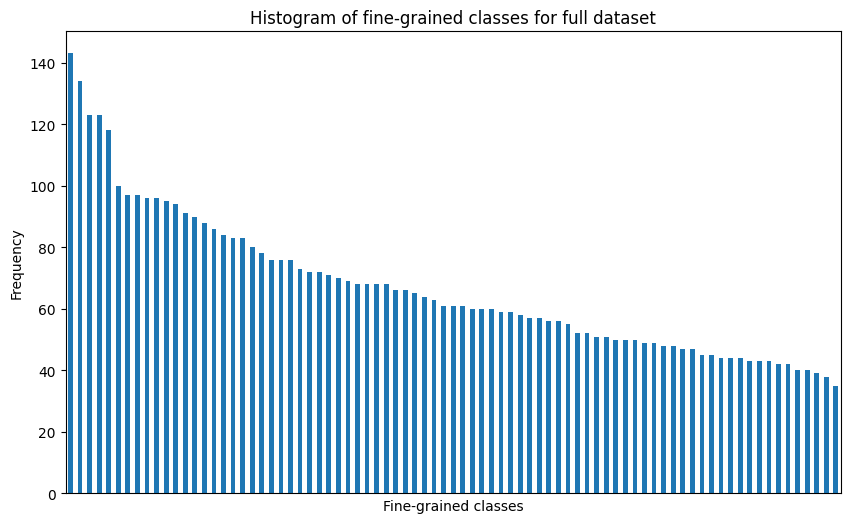

In [ ]:
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

plt.figure(figsize=(10, 6))

# Count the occurrences of each 'Class ID (Fine)' and plot
combined_df['Class ID (Fine)'].value_counts().sort_values(ascending=False).plot(kind='bar')

# Labeling the axes
plt.xlabel('Fine-grained classes')
plt.ylabel('Frequency')
plt.xticks([])
plt.title('Histogram of fine-grained classes for full dataset')

# Show the plot
plt.savefig("histogram_fine.jpg")
plt.show()

# Plot coarse-grained histogram

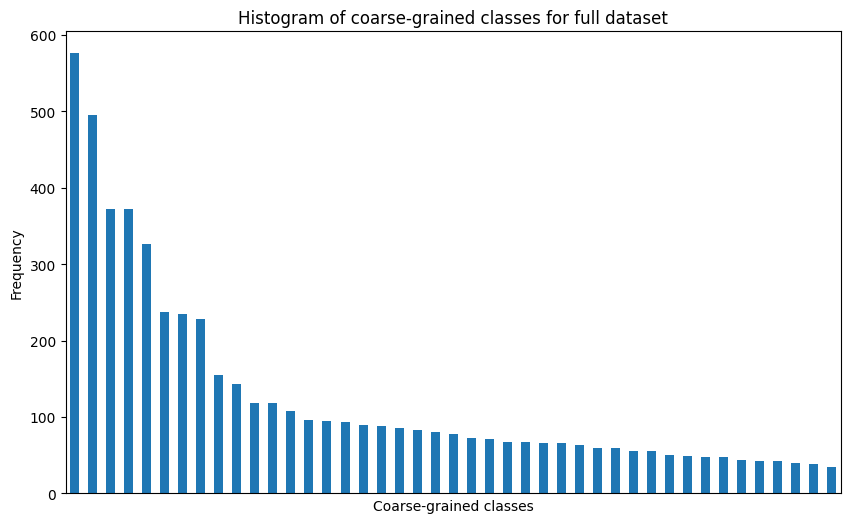

In [ ]:
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

plt.figure(figsize=(10, 6))

# Count the occurrences of each 'Class ID (Fine)' and plot
combined_df['Class ID (Coarse)'].value_counts().sort_values(ascending=False).plot(kind='bar')

# Labeling the axes
plt.xlabel('Coarse-grained classes')
plt.ylabel('Frequency')
plt.xticks([])
plt.title('Histogram of coarse-grained classes for full dataset')

# Show the plot
plt.savefig("histogram_coarse.jpg")
plt.show()

#Split dataset into train, test, and val set

In [ ]:
X_train = load_natural_images(train_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_train_classification = to_categorical(train_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_train_reg = train_df["Price (piece)"]

X_val = load_natural_images(val_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_val_classification = to_categorical(val_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_val_reg = val_df["Price (piece)"]

X_test = load_natural_images(test_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_test_classification = to_categorical(test_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_test_reg = test_df["Price (piece)"]

# Build the six models utilized in thesis

1. C1 - Classification - Categorical cross entropy
2. R1 - Regression - MSE
3. R1 - Regression - Custom asymmetric loss
4. MTL1 - Integrated Custom Loss Function - Categorical cross entropy & MSE
5. MTL2 - Weighted Multi-Output Loss - Categorical cross entropy & MSE
6. MTL3 - Weighted Multi-Output Loss - Categorical cross entropy & Custom asymmetric loss

In [ ]:
class CustomLearningRateScheduler(Callback):
    """ Custom learning rate scheduler that decreases the learning rate by a fixed
    decay rate after each epoch.
    """
    def __init__(self, initial_lr, decay_amount):
        super().__init__()
        self.initial_lr = initial_lr
        self.decay_amount = decay_amount

    def on_epoch_end(self, epoch, logs=None):
        # New learning rate after decay
        new_lr = self.initial_lr - (self.decay_amount * (epoch + 1))
        # Update the model's learning rate
        K.set_value(self.model.optimizer.lr, new_lr)
        # Log the current learning rate
        print(f'\nEpoch {epoch+1}: Learning rate is now {new_lr:.6f}.')

# 1. C1 Model - Classification


In [ ]:
initial_lr = 0.001
decay_amount = 1e-6  # Fixed amount of decay for the lr by each epoch
custom_lr_scheduler = CustomLearningRateScheduler(initial_lr, decay_amount)

In [ ]:
baseModel = DenseNet169(weights='imagenet', include_top=False)
#With include_top=False I remove the final fully connected layer from the DenseNet

epochs_choice = 60
batch_size = 32

#Construct my own head, which will be put on top of the BaseModel
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(81, activation="softmax")(headModel)

#combine models
model = Model(inputs=baseModel.input, outputs=headModel)

model_checkpoint = ModelCheckpoint('best_model1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

opt = SGD(learning_rate=initial_lr, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

print("Start training:")
His_model_1 = model.fit(
    X_train,
    y_train_classification,
    validation_data=(X_val, y_val_classification),
    batch_size = batch_size,
    epochs=epochs_choice,
    callbacks=[custom_lr_scheduler, model_checkpoint])


## Plotting


In [ ]:
best_model_epoch = 52

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training loss and validation loss
ax1.plot(np.arange(1, epochs_choice + 1), His_model_1.history["loss"], label="Training Loss")
ax1.plot(np.arange(1, epochs_choice + 1), His_model_1.history["val_loss"], label="Validation Loss")
ax1.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax1.grid()

# Title and labels for the loss plot
ax1.set_title("Training and Validation Loss - Classification")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

# Plot training accuracy and validation accuracy
ax2.plot(np.arange(1, epochs_choice + 1), His_model_1.history["accuracy"], label="Training Accuracy")
ax2.plot(np.arange(1, epochs_choice + 1), His_model_1.history["val_accuracy"], label="Validation Accuracy")
ax2.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax2.grid()

# Title and labels for the accuracy plot
ax2.set_title("Training and Validation Accuracy - Classification")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots to separate files
plt.savefig("C1_loss_acc.png")
plt.show()

## Evaluation metrics validation

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model1.h5')
loss, accuracy = best_model.evaluate(X_val, y_val_classification, verbose=0)

# Predict on test set
predictions = best_model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val_classification, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

# Print metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

## Evaluation metrics test

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model1.h5')
loss, accuracy = best_model.evaluate(X_test, y_test_classification, verbose=0)

# Predict on test set
predictions = best_model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test_classification, axis=1)

# Calculate metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

# Print metrics
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
del model, X_train, y_train_classification, X_val, y_val_classification, predictions

In [ ]:
X_train = load_natural_images(train_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_train_classification = to_categorical(train_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_train_reg = train_df["Price (piece)"]

X_val = load_natural_images(val_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_val_classification = to_categorical(val_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_val_reg = val_df["Price (piece)"]

X_test = load_natural_images(test_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_test_classification = to_categorical(test_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_test_reg = test_df["Price (piece)"]

# 2. R1 - Regression - MSE

In [ ]:
baseModel = DenseNet169(weights='imagenet', include_top=False)
 #With include_top=False I remove the final fully connected layer from the DenseNet

epochs_choice = 60
batch_size = 32

model_checkpoint = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

#Construct my own head, which will be put on top of the BaseModel
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="linear", name="price_output")(headModel)

#combine models
model = Model(inputs=baseModel.input, outputs=headModel)


opt =Adam(learning_rate=1e-4)

model.compile(loss="mean_squared_error", optimizer=opt)

print("Start training:")
His_model_2 = model.fit(
    X_train,
    y_train_reg,
    validation_data=(X_val, y_val_reg),
    batch_size = batch_size,
    epochs=epochs_choice,
    callbacks=[model_checkpoint])

##Plot loss


In [ ]:
best_model_epoch = 54

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, epochs_choice + 1), His_model_2.history["loss"], label="Training Loss")
plt.plot(np.arange(1, epochs_choice + 1), His_model_2.history["val_loss"], label="Validation Loss")
plt.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss - Regression')
plt.savefig("R1_loss")
plt.show()

## Evaluation metrics - validation

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model2.h5')

mse_loss = best_model.evaluate(X_val, y_val_reg, verbose=0)

# Predict on val set
predictions = best_model.predict(X_val)

# Calculate R-squared
r_squared = r2_score(y_val_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse_loss}")
print(f"R-squared: {r_squared}")

10/10 [==============================] - 4s 121ms/step
MSE Loss: 0.09160644561052322
R-squared: -1.2923521924799442


##Evaluation metrics - test





In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model2.h5')


mse_loss = best_model.evaluate(X_test, y_test_reg, verbose=0)

# Predict on test set
predictions = best_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse_loss}")
print(f"R-squared: {r_squared}")

78/78 [==============================] - 12s 116ms/step
MSE Loss: 0.07141085714101791
R-squared: 0.8531289666659561


## Residuals plot

In [ ]:
y_test_reg = np.array(y_test_reg).ravel()
predicted_prices_test = np.array(predictions).ravel()
residuals = y_test_reg - predicted_prices_test

# Verify that both arrays have the same length
assert len(y_test_reg) == len(predicted_prices_test), "Data size mismatch."

# Calculate the average residual
average_residual = np.mean(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(predicted_prices_test, residuals)
plt.grid()
plt.xlabel('Predicted prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.axhline(y=average_residual, color='g', linestyle='--', label=f'Avg Residual: {average_residual:.2f}')
plt.title('Residual Plot')

# Display the legend
plt.legend()
plt.savefig("R1_residuals.png")
plt.show()

## Get average predicted prices for R1 model


In [ ]:
#Create the mapping from fine to coarse class names
fine_to_coarse_mapping = dict(zip(classes_df["Class ID (Fine)"], classes_df["Coarse Class Name (str)"]))

#Label each image in the test set with its coarse-grained class
test_df["Coarse Class Name (str)"] = test_df["Class ID (Fine)"].map(fine_to_coarse_mapping)
best_model = load_model('best_model2.h5')

predictions = best_model.predict(X_test)
test_df["predicted_price"] = predictions

#Group by the coarse-grained class and compute the average predicted price
average_predicted_prices_coarse = test_df.groupby("Coarse Class Name (str)")["predicted_price"].mean()

# Convert to Df
df_coarse = average_predicted_prices_coarse.reset_index()
df_coarse.columns = ['Coarse Grained Classes', 'Predicted Prices']

df_coarse.to_excel("predicted_prices_R1.xlsx", index=False)

In [ ]:
del model, X_train, y_train_reg, X_val, y_val_reg, predictions

In [ ]:
X_train = load_natural_images(train_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_train_classification = to_categorical(train_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_train_reg = train_df["Price (piece)"]

X_val = load_natural_images(val_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_val_classification = to_categorical(val_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_val_reg = val_df["Price (piece)"]

X_test = load_natural_images(test_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_test_classification = to_categorical(test_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_test_reg = test_df["Price (piece)"]

# 3. R2 - Regression - Custom asymmetric loss

In [ ]:
theta_r = 10.0  # Hyperparameter
alpha_r = 1.0  # Hyperparameter
psi_r = 10.0    # Hyperparameter
loss_type = "exponential"  # Hyperparameter

def asymmetric_loss(y_true, y_pred):

    residuals = y_true - y_pred

    left_loss = tf.where(residuals < 0, residuals**2, 0.0)

    if loss_type == 'linear':
        right_loss = alpha_r * theta_r * (2*residuals - theta_r)
    elif loss_type == 'exponential':
        right_loss = alpha_r * theta_r * (theta_r + 2 * psi_r * (tf.exp((residuals - theta_r) / psi_r) - 1))
    elif loss_type == 'quadratic':
        right_loss = alpha_r * residuals**2
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}")

    right_conditioned_loss = tf.where(residuals >= theta_r, right_loss, alpha_r * residuals**2)

    return left_loss + right_conditioned_loss

## Assymetric loss function plotting:

In [ ]:
def plot_losses():
    residual_range = np.linspace(-20, 20, 400)
    y_true_vals = np.zeros_like(residual_range)
    asymmetric_losses = []
    mse_losses = []

    for r in residual_range:
        y_pred_val = y_true_vals - r

        loss_asym = asymmetric_loss(tf.constant(y_true_vals, dtype=tf.float32),
                                    tf.constant(y_pred_val, dtype=tf.float32))
        asymmetric_losses.append(np.mean(loss_asym))

        loss_mse = tf.reduce_mean(tf.square(r))
        mse_losses.append(loss_mse)

    plt.figure(figsize=(10, 6))
    plt.plot(residual_range, asymmetric_losses, label='Asymmetric loss', color='orange')
    plt.plot(residual_range, mse_losses, label='MSE (symmetric)', color='blue')
    plt.axvline(x=theta_r, linestyle='--', color='purple', label='θ')
    plt.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    plt.title('Comparison of Loss Functions')
    plt.xlabel('Residuals')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_losses()

## Implementing into model

In [ ]:
baseModel = DenseNet169(weights='imagenet', include_top=False)
 #With include_top=False I remove the final fully connected layer from the DenseNet

epochs_choice = 60
batch_size = 32

#Construct my own head, which will be put on top of the BaseModel
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="linear", name="price_output")(headModel)

#combine models
model = Model(inputs=baseModel.input, outputs=headModel)
model_checkpoint = ModelCheckpoint('best_model3.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

opt =Adam(learning_rate=1e-4)

model.compile(loss=asymmetric_loss, optimizer=opt)

print("Start training:")
His_model_3 = model.fit(
    X_train,
    y_train_reg,
    validation_data=(X_val, y_val_reg),
    batch_size = batch_size,
    epochs=epochs_choice,
    callbacks=[model_checkpoint])

##Plot regression model


In [ ]:
best_model_epoch = 56

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, epochs_choice + 1), His_model_3.history["loss"], label="Training Loss")
plt.plot(np.arange(1, epochs_choice + 1), His_model_3.history["val_loss"], label="Validation Loss")
plt.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss - Regression')
plt.savefig("R2_loss.png")
plt.show()

## Evaluation metrics - validation

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model3.h5', custom_objects={'asymmetric_loss': asymmetric_loss})

mse_loss = best_model.evaluate(X_val, y_val_reg, verbose=0)

# Predict on test set
predictions = best_model.predict(X_val)

# Calculate R-squared
r_squared = r2_score(y_val_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse_loss}")
print(f"R-squared: {r_squared}")

##Evaluation metrics - test





In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model3.h5', custom_objects={'asymmetric_loss': asymmetric_loss})


mse_loss = best_model.evaluate(X_test, y_test_reg, verbose=0)

# Predict on test set
predictions = best_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse_loss}")
print(f"R-squared: {r_squared}")

78/78 [==============================] - 12s 123ms/step
MSE Loss: 22.019554138183594
R-squared: 0.8762356476137393


## Residuals plot

In [ ]:
y_test_reg = np.array(y_test_reg).ravel()
predicted_prices_test = np.array(predictions).ravel()
residuals = y_test_reg - predicted_prices_test

# Verify that both arrays have the same length
assert len(y_test_reg) == len(predicted_prices_test), "Data size mismatch."

# Calculate the average residual
average_residual = np.mean(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(predicted_prices_test, residuals)
plt.grid()
plt.xlabel('Predicted prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.axhline(y=average_residual, color='g', linestyle='--', label=f'Avg Residual: {average_residual:.2f}')
plt.title('Residual Plot')

# Display the legend
plt.legend()
plt.savefig("R2_residuals.png")
plt.show()

## Get average predicted prices for R2 model

In [ ]:
#Create the mapping from fine to coarse class names
fine_to_coarse_mapping = dict(zip(classes_df["Class ID (Fine)"], classes_df["Coarse Class Name (str)"]))

#Label each image in the test set with its coarse-grained class
test_df["Coarse Class Name (str)"] = test_df["Class ID (Fine)"].map(fine_to_coarse_mapping)
best_model = load_model('best_model3.h5', custom_objects={'asymmetric_loss': asymmetric_loss})


predictions = best_model.predict(X_test)
test_df["predicted_price"] = predictions

#Group by the coarse-grained class and compute the average predicted price
average_predicted_prices_coarse = test_df.groupby("Coarse Class Name (str)")["predicted_price"].mean()

# Convert to Df
df_coarse = average_predicted_prices_coarse.reset_index()
df_coarse.columns = ['Coarse Grained Classes', 'Predicted Prices']

df_coarse.to_excel("predicted_prices_R2.xlsx", index=False)

78/78 [==============================] - 12s 122ms/step


In [ ]:
del model, X_train, y_train_reg, X_val, y_val_reg, predictions

In [ ]:
X_train = load_natural_images(train_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_train_classification = to_categorical(train_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_train_reg = train_df["Price (piece)"]

X_val = load_natural_images(val_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_val_classification = to_categorical(val_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_val_reg = val_df["Price (piece)"]

X_test = load_natural_images(test_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_test_classification = to_categorical(test_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_test_reg = test_df["Price (piece)"]

# 4. MTL1 - Integrated Custom Loss Function - Categorical cross entropy & MSE

## Create own loss function to combine regression and classification

In [ ]:
def custom_loss(y_true, y_pred):
    classification_loss = categorical_crossentropy(y_true[0], y_pred[0])
    price_true = y_true[1]
    price_pred = y_pred[1]
    price_loss = mean_squared_error(price_true, price_pred)
    loss_weight = 0.9  # hyperparameter

    residual = price_true - price_pred

    # Combine classification loss, price loss, and penalty term
    total_loss = loss_weight*classification_loss + (1-loss_weight) * price_loss
    return total_loss

## Implementing into model

In [ ]:
initial_lr = 1e-4
decay_amount = 1e-6  # Fixed amount of decay for the lr by each epoch
custom_lr_scheduler = CustomLearningRateScheduler(initial_lr, decay_amount)

In [ ]:
baseModel = DenseNet169(weights='imagenet', include_top=False)
 #With include_top=False I remove the final fully connected layer from the DenseNet

epochs_choice = 120
batch_size = 32

#Construct my own head, which will be put on top of the BaseModel
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
classification_output = Dense(81, activation="softmax", name="classification_output")(headModel)

price_output = Dense(1, activation="linear", name="price_output")(headModel)

#combine model
model = Model(inputs=baseModel.input, outputs=[classification_output, price_output])
model_checkpoint = ModelCheckpoint('best_model4.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


optimizer_total = SGD(learning_rate=1e-4, momentum=0.9)

model.compile(
    loss=custom_loss,
    loss_weights={"classification_output": 0.9, "price_output": 0.1},  # Adjust weight for each output according to importans
    optimizer=optimizer_total,
    metrics={"classification_output": "accuracy", "price_output": "mean_squared_error"}
)


His_model_4 = model.fit(
    X_train,
    {"classification_output": y_train_classification, "price_output": y_train_reg},
    validation_data=(X_val, {"classification_output": y_val_classification, "price_output": y_val_reg}),
    batch_size = batch_size,
    epochs=epochs_choice,
    callbacks=[custom_lr_scheduler, model_checkpoint]
)


## Plots


In [ ]:
best_model_epoch = 71
# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training loss and validation loss
ax1.plot(np.arange(1, epochs_choice + 1), His_model_4.history["classification_output_loss"], label="Training Loss")
ax1.plot(np.arange(1, epochs_choice + 1), His_model_4.history["val_classification_output_loss"], label="Validation Loss")
ax1.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax1.grid()

# Title and labels for the loss plot
ax1.set_title("Training and Validation Loss - Classification")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

# Plot training accuracy and validation accuracy
ax2.plot(np.arange(1, epochs_choice + 1), His_model_4.history["classification_output_accuracy"], label="Training Accuracy")
ax2.plot(np.arange(1, epochs_choice + 1), His_model_4.history["val_classification_output_accuracy"], label="Validation Accuracy")
ax2.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax2.grid()

# Title and labels for the accuracy plot
ax2.set_title("Training and Validation Accuracy - Classification")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots to separate files
plt.savefig("MTL1_class_loss.png")
plt.show()

In [ ]:
best_model_epoch = 71

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, epochs_choice + 1), His_model_4.history["price_output_mean_squared_error"], label="Training Loss")
plt.plot(np.arange(1, epochs_choice + 1), His_model_4.history["val_price_output_mean_squared_error"], label="Validation Loss")
plt.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss - Regression')
plt.savefig("MTL1_reg_loss")
plt.show()

#Evaluation metrics regression - validation

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model4.h5', custom_objects={'custom_loss': custom_loss})

predictions = best_model.predict(X_val)[1]
predictions = np.squeeze(predictions)

# Calculate MSE
mse = mean_squared_error(y_val_reg, predictions)

# Calculate R-squared
r2 = r2_score(y_val_reg, predictions)

print(f"MSE: {mse}")
print(f"R-squared: {r2}")

#Evaluation metrics regression - test





In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model4.h5', custom_objects={'custom_loss': custom_loss})

# Evaluate the model on the test set to get MSE as the loss
predictions = best_model.predict(X_test)[1]
predictions = np.squeeze(predictions)

# Calculate MSE
mse = mean_squared_error(y_test_reg, predictions)

# Calculate R-squared
r_squared = r2_score(y_test_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse}")
print(f"R-squared: {r_squared}")

## Residuals plot

In [ ]:
y_test_reg = np.array(y_test_reg).ravel()
predicted_prices_test = np.array(predictions).ravel()
residuals = y_test_reg - predicted_prices_test

# Verify that both arrays have the same length
assert len(y_test_reg) == len(predicted_prices_test), "Data size mismatch."

# Calculate the average residual
average_residual = np.mean(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(predicted_prices_test, residuals)
plt.grid()
plt.xlabel('Predicted prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.axhline(y=average_residual, color='g', linestyle='--', label=f'Avg Residual: {average_residual:.2f}')
plt.title('Residual Plot')

# Display the legend
plt.legend()

plt.savefig("MTL1_residuals.png")
plt.show()

## Get average predicted prices for MTL1 model

In [ ]:
#Create the mapping from fine to coarse class names
fine_to_coarse_mapping = dict(zip(classes_df["Class ID (Fine)"], classes_df["Coarse Class Name (str)"]))

#Label each image in the test set with its coarse-grained class
test_df["Coarse Class Name (str)"] = test_df["Class ID (Fine)"].map(fine_to_coarse_mapping)
best_model = load_model('best_model4.h5', custom_objects={'custom_loss': custom_loss})


predicted_prices = best_model.predict(X_test)[1]
test_df["predicted_price"] = predicted_prices

#Group by the coarse-grained class and compute the average predicted price
average_predicted_prices_coarse = test_df.groupby("Coarse Class Name (str)")["predicted_price"].mean()

# Convert to Df
df_coarse = average_predicted_prices_coarse.reset_index()
df_coarse.columns = ['Coarse Grained Classes', 'Predicted Prices']

df_coarse.to_excel("predicted_prices_MTL1.xlsx", index=False)

## Evaluation metrics classification - test

In [ ]:
# Load the best model
best_model = load_model('best_model4.h5', custom_objects={'custom_loss': custom_loss})

# Evaluate the model on the test set

# Predict on test set
predictions = best_model.predict(X_test)

# Extract predictions for classification and price
classification_predictions = predictions[0]

# For classification
predicted_classes = np.argmax(classification_predictions, axis=1)
true_classes = np.argmax(y_test_classification, axis=1)  # assuming y_test_classification is one-hot encoded

# Calculate classification metrics
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
accuracy = accuracy_score(true_classes, predicted_classes)

classification_loss = categorical_crossentropy(K.constant(y_test_classification), K.constant(classification_predictions))
classification_loss = K.mean(classification_loss).numpy()  # Convert to numpy array and take mean

# Print metrics
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {accuracy}")
print(f"Classification Precision: {precision}")
print(f"Classification Recall: {recall}")
print(f"Classification F1 Score: {f1}")

78/78 [==============================] - 12s 123ms/step
Classification Loss: 1.0015467405319214
Classification Accuracy: 0.758148893360161
Classification Precision: 0.7818792683201944
Classification Recall: 0.7417508895980096
Classification F1 Score: 0.7330264453676495


## Evaluation metrics classification - validation

In [ ]:
# Load the best model
best_model = load_model('best_model4.h5', custom_objects={'custom_loss': custom_loss})

# Predict on validation set
predictions = best_model.predict(X_val)

# Extract predictions for classification
classification_predictions = predictions[0]

# For classification
predicted_classes = np.argmax(classification_predictions, axis=1)
true_classes = np.argmax(y_val_classification, axis=1)  # assuming y_val_classification is one-hot encoded

# Calculate classification metrics
precision = precision_score(true_classes, predicted_classes, average='macro', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='macro', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='macro', zero_division=0)
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate classification loss
classification_loss = categorical_crossentropy(K.constant(y_val_classification), K.constant(classification_predictions))
classification_loss = K.mean(classification_loss).numpy()  # Convert to numpy array and take mean

# Print metrics
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {accuracy}")
print(f"Classification Precision: {precision}")
print(f"Classification Recall: {recall}")
print(f"Classification F1 Score: {f1}")

10/10 [==============================] - 8s 125ms/step
Classification Loss: 1.3604412078857422
Classification Accuracy: 0.6587837837837838
Classification Precision: 0.6209423426814732
Classification Recall: 0.5760869565217391
Classification F1 Score: 0.5697018612821546


In [ ]:
del model, X_train, y_train_reg, y_train_classification, X_val, y_val_reg, y_val_classification, predictions

In [ ]:
X_train = load_natural_images(train_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_train_classification = to_categorical(train_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_train_reg = train_df["Price (piece)"]

X_val = load_natural_images(val_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_val_classification = to_categorical(val_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_val_reg = val_df["Price (piece)"]

X_test = load_natural_images(test_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_test_classification = to_categorical(test_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_test_reg = test_df["Price (piece)"]

# 5. MTL2 - Weighted Multi-Output Loss - Categorical cross entropy & MSE

In [ ]:
baseModel = DenseNet169(weights='imagenet', include_top=False)
 #With include_top=False I remove the final fully connected layer from the DenseNet

epochs_choice = 80
batch_size = 32

#Construct my own head, which will be put on top of the BaseModel
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
classification_output = Dense(81, activation="softmax", name="classification_output")(headModel)

price_output = Dense(1, activation="linear", name="price_output")(headModel)

#combine model
model = Model(inputs=baseModel.input, outputs=[classification_output, price_output])
model_checkpoint = ModelCheckpoint('best_model5.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

optimizer_total = SGD(learning_rate=1e-4, momentum=0.9)

# Compile the model with separate optimizers for each output
model.compile(
    loss={"classification_output": "categorical_crossentropy", "price_output": "mean_squared_error"},
    loss_weights={"classification_output": 0.9, "price_output": 0.1},  # Adjust weight for each output according to importans
    optimizer=optimizer_total,
    metrics={"classification_output": "accuracy", "price_output": "mean_squared_error"}
)


His_model_5 = model.fit(
    X_train,
    {"classification_output": y_train_classification, "price_output": y_train_reg},
    validation_data=(X_val, {"classification_output": y_val_classification, "price_output": y_val_reg}),
    batch_size = batch_size,
    epochs=epochs_choice,
    callbacks=[custom_lr_scheduler, model_checkpoint]
)


## Plots and evaluation metrics

In [ ]:
best_model_epoch = 65
# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training loss and validation loss
ax1.plot(np.arange(1, epochs_choice + 1), His_model_5.history["classification_output_loss"], label="Training Loss")
ax1.plot(np.arange(1, epochs_choice + 1), His_model_5.history["val_classification_output_loss"], label="Validation Loss")
ax1.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax1.grid()

# Title and labels for the loss plot
ax1.set_title("Training and Validation Loss - Classification")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

# Plot training accuracy and validation accuracy
ax2.plot(np.arange(1, epochs_choice + 1), His_model_5.history["classification_output_accuracy"], label="Training Accuracy")
ax2.plot(np.arange(1, epochs_choice + 1), His_model_5.history["val_classification_output_accuracy"], label="Validation Accuracy")
ax2.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax2.grid()

# Title and labels for the accuracy plot
ax2.set_title("Training and Validation Accuracy - Classification")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots to separate files
plt.savefig("MTL2_class_loss.png")
plt.show()

In [ ]:
best_model_epoch = 65

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, epochs_choice + 1), His_model_5.history["price_output_mean_squared_error"], label="Training Loss")
plt.plot(np.arange(1, epochs_choice + 1), His_model_5.history["val_price_output_mean_squared_error"], label="Validation Loss")
plt.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss - Regression')
plt.savefig("MTL2_reg_loss")
plt.show()

##Evaluation metrics regression - validation

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model5.h5')

predictions = best_model.predict(X_val)[1]
predictions = np.squeeze(predictions)

# Calculate MSE
mse = mean_squared_error(y_val_reg, predictions)

# Calculate R-squared
r2 = r2_score(y_val_reg, predictions)

print(f"MSE: {mse}")
print(f"R-squared: {r2}")

##Evaluation metrics regression - test





In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model5.h5')


predictions = best_model.predict(X_test)[1]
predictions = np.squeeze(predictions)

# Calculate MSE
mse = mean_squared_error(y_test_reg, predictions)

# Calculate R-squared
r_squared = r2_score(y_test_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse}")
print(f"R-squared: {r_squared}")

## Residuals plot

In [ ]:
y_test_reg = np.array(y_test_reg).ravel()
predicted_prices_test = np.array(predictions).ravel()
residuals = y_test_reg - predicted_prices_test

# Verify that both arrays have the same length
assert len(y_test_reg) == len(predicted_prices_test), "Data size mismatch."

# Calculate the average residual
average_residual = np.mean(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(predicted_prices_test, residuals)
plt.grid()
plt.xlabel('Predicted prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.axhline(y=average_residual, color='g', linestyle='--', label=f'Avg Residual: {average_residual:.2f}')
plt.title('Residual Plot')

# Display the legend
plt.legend()

plt.savefig("MTL2_residuals.png")
plt.show()

## Get average predicted prices for MTL2 model

In [ ]:
#Create the mapping from fine to coarse class names
fine_to_coarse_mapping = dict(zip(classes_df["Class ID (Fine)"], classes_df["Coarse Class Name (str)"]))

#Label each image in the test set with its coarse-grained class
test_df["Coarse Class Name (str)"] = test_df["Class ID (Fine)"].map(fine_to_coarse_mapping)
best_model = load_model('best_model5.h5')


predicted_prices = best_model.predict(X_test)[1]
test_df["predicted_price"] = predicted_prices

#Group by the coarse-grained class and compute the average predicted price
average_predicted_prices_coarse = test_df.groupby("Coarse Class Name (str)")["predicted_price"].mean()

# Convert to Df
df_coarse = average_predicted_prices_coarse.reset_index()
df_coarse.columns = ['Coarse Grained Classes', 'Predicted Prices']

df_coarse.to_excel("predicted_prices_MTL2.xlsx", index=False)

## Evaluation metrics classification - test

In [ ]:
# Load the best model
best_model = load_model('best_model5.h5')

# Evaluate the model on the test set

# Predict on test set
predictions = best_model.predict(X_test)

# Extract predictions for classification and price
classification_predictions = predictions[0]

# For classification
predicted_classes = np.argmax(classification_predictions, axis=1)
true_classes = np.argmax(y_test_classification, axis=1)

# Calculate classification metrics
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
accuracy = accuracy_score(true_classes, predicted_classes)

classification_loss = categorical_crossentropy(K.constant(y_test_classification), K.constant(classification_predictions))
classification_loss = K.mean(classification_loss).numpy()  # Convert to numpy array and take mean

# Print metrics
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {accuracy}")
print(f"Classification Precision: {precision}")
print(f"Classification Recall: {recall}")
print(f"Classification F1 Score: {f1}")

## Evaluation metrics classification - validation

In [ ]:
# Load the best model
best_model = load_model('best_model5.h5')

# Predict on validation set
predictions = best_model.predict(X_val)

# Extract predictions for classification
classification_predictions = predictions[0]

# For classification
predicted_classes = np.argmax(classification_predictions, axis=1)
true_classes = np.argmax(y_val_classification, axis=1)

# Calculate classification metrics
precision = precision_score(true_classes, predicted_classes, average='macro', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='macro', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='macro', zero_division=0)
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate classification loss
classification_loss = categorical_crossentropy(K.constant(y_val_classification), K.constant(classification_predictions))
classification_loss = K.mean(classification_loss).numpy()  # Convert to numpy array and take mean

# Print metrics
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {accuracy}")
print(f"Classification Precision: {precision}")
print(f"Classification Recall: {recall}")
print(f"Classification F1 Score: {f1}")

In [ ]:
del model, X_train, y_train_reg, y_train_classification, X_val, y_val_reg, y_val_classification, predictions

In [ ]:
X_train = load_natural_images(train_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_train_classification = to_categorical(train_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_train_reg = train_df["Price (piece)"]

X_val = load_natural_images(val_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_val_classification = to_categorical(val_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_val_reg = val_df["Price (piece)"]

X_test = load_natural_images(test_df["0"], img_size=[224, 224, 3], base_dir = 'GroceryStoreDataset/dataset/')
y_test_classification = to_categorical(test_df["Class ID (Fine)"], num_classes=81) # One hot encoding
y_test_reg = test_df["Price (piece)"]

# 6. MTL3 - Weighted Multi-Output Loss - Categorical cross entropy & Custom asymmetric loss

In [ ]:
baseModel = DenseNet169(weights='imagenet', include_top=False)
 #With include_top=False I remove the final fully connected layer from the DenseNet

epochs_choice = 80
batch_size = 32


#Construct my own head, which will be put on top of the BaseModel
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
classification_output = Dense(81, activation="softmax", name="classification_output")(headModel)

price_output = Dense(1, activation="linear", name="price_output")(headModel)

#combine model
model = Model(inputs=baseModel.input, outputs=[classification_output, price_output])
model_checkpoint = ModelCheckpoint('best_model6.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)


optimizer_total = SGD(learning_rate=1e-4, momentum=0.9)


model.compile(
    loss={"classification_output": "categorical_crossentropy", "price_output": asymmetric_loss},
    loss_weights={"classification_output": 0.9, "price_output": 0.1},  # Adjust weight for each output according to importans
    optimizer=optimizer_total,
    metrics={"classification_output": "accuracy", "price_output": "mean_squared_error"}
)


His_model_6 = model.fit(
    X_train,
    {"classification_output": y_train_classification, "price_output": y_train_reg},
    validation_data=(X_val, {"classification_output": y_val_classification, "price_output": y_val_reg}),
    batch_size = batch_size,
    epochs=epochs_choice,
    callbacks=[custom_lr_scheduler, model_checkpoint]
)

## Plots and evaluation metrics


In [ ]:
best_model_epoch = 67
# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training loss and validation loss
ax1.plot(np.arange(1, epochs_choice + 1), His_model_6.history["classification_output_loss"], label="Training Loss")
ax1.plot(np.arange(1, epochs_choice + 1), His_model_6.history["val_classification_output_loss"], label="Validation Loss")
ax1.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax1.grid()

# Title and labels for the loss plot
ax1.set_title("Training and Validation Loss - Classification")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend(loc="upper right")

# Plot training accuracy and validation accuracy
ax2.plot(np.arange(1, epochs_choice + 1), His_model_6.history["classification_output_accuracy"], label="Training Accuracy")
ax2.plot(np.arange(1, epochs_choice + 1), His_model_6.history["val_classification_output_accuracy"], label="Validation Accuracy")
ax2.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
ax2.grid()

# Title and labels for the accuracy plot
ax2.set_title("Training and Validation Accuracy - Classification")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="lower right")

# Adjust spacing between subplots
plt.tight_layout()

# Save the plots to separate files
plt.savefig("MTL3_class_loss.png")
plt.show()

In [ ]:
best_model_epoch = 67

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, epochs_choice + 1), His_model_6.history["price_output_mean_squared_error"], label="Training Loss")
plt.plot(np.arange(1, epochs_choice + 1), His_model_6.history["val_price_output_mean_squared_error"], label="Validation Loss")
plt.axvline(x=best_model_epoch, color='r', linestyle='--', label='Epoch With Lowest Loss')
plt.grid()

plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss - Regression')
plt.savefig("MTL3_reg_loss")
plt.show()

#Evaluation metrics regression - validation

In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model6.h5', custom_objects={'asymmetric_loss': asymmetric_loss})

predictions = best_model.predict(X_val)[1]
predictions = np.squeeze(predictions)

# Calculate MSE
mse = mean_squared_error(y_val_reg, predictions)

# Calculate R-squared
r2 = r2_score(y_val_reg, predictions)

print(f"MSE: {mse}")
print(f"R-squared: {r2}")

#Evaluation metrics regression - test





In [ ]:
# Load the best model from checkpoint
best_model = load_model('best_model6.h5', custom_objects={'asymmetric_loss': asymmetric_loss})

predictions = best_model.predict(X_test)[1]
predictions = np.squeeze(predictions)

# Calculate MSE
mse = mean_squared_error(y_test_reg, predictions)

# Calculate R-squared
r_squared = r2_score(y_test_reg, predictions)

# Print metrics
print(f"MSE Loss: {mse}")
print(f"R-squared: {r_squared}")

## Residuals plot


In [ ]:
y_test_reg = np.array(y_test_reg).ravel()
predicted_prices_test = np.array(predictions).ravel()
residuals = y_test_reg - predicted_prices_test

# Verify that both arrays have the same length
assert len(y_test_reg) == len(predicted_prices_test), "Data size mismatch."

# Calculate the average residual
average_residual = np.mean(residuals)

plt.figure(figsize=(8, 6))
plt.scatter(predicted_prices_test, residuals)
plt.grid()
plt.xlabel('Predicted prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual')
plt.axhline(y=average_residual, color='g', linestyle='--', label=f'Avg Residual: {average_residual:.2f}')
plt.title('Residual Plot')

# Display the legend
plt.legend()

plt.savefig("MTL3_residuals.png")
plt.show()

## Get average predicted prices for MTL3 model

In [ ]:
#Create the mapping from fine to coarse class names
fine_to_coarse_mapping = dict(zip(classes_df["Class ID (Fine)"], classes_df["Coarse Class Name (str)"]))

#Label each image in the test set with its coarse-grained class
test_df["Coarse Class Name (str)"] = test_df["Class ID (Fine)"].map(fine_to_coarse_mapping)
best_model = load_model('best_model6.h5', custom_objects={'asymmetric_loss': asymmetric_loss})


predicted_prices = best_model.predict(X_test)[1]
test_df["predicted_price"] = predicted_prices

#Group by the coarse-grained class and compute the average predicted price
average_predicted_prices_coarse = test_df.groupby("Coarse Class Name (str)")["predicted_price"].mean()

# Convert to Df
df_coarse = average_predicted_prices_coarse.reset_index()
df_coarse.columns = ['Coarse Grained Classes', 'Predicted Prices']

df_coarse.to_excel("predicted_prices_MTL3.xlsx", index=False)

## Evaluation metrics classification - test

In [ ]:
# Load the best model
best_model = load_model('best_model6.h5', custom_objects={'asymmetric_loss': asymmetric_loss})

# Evaluate the model on the test set

# Predict on test set
predictions = best_model.predict(X_test)

# Extract predictions for classification and price
classification_predictions = predictions[0]

# For classification
predicted_classes = np.argmax(classification_predictions, axis=1)
true_classes = np.argmax(y_test_classification, axis=1)

# Calculate classification metrics
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')
accuracy = accuracy_score(true_classes, predicted_classes)

classification_loss = categorical_crossentropy(K.constant(y_test_classification), K.constant(classification_predictions))
classification_loss = K.mean(classification_loss).numpy()  # Convert to numpy array and take mean

# Print metrics
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {accuracy}")
print(f"Classification Precision: {precision}")
print(f"Classification Recall: {recall}")
print(f"Classification F1 Score: {f1}")

## Evaluation metrics classification - validation

In [ ]:
# Load the best model
best_model = load_model('best_model6.h5', custom_objects={'asymmetric_loss': asymmetric_loss})

# Predict on validation set
predictions = best_model.predict(X_val)

# Extract predictions for classification
classification_predictions = predictions[0]

# For classification
predicted_classes = np.argmax(classification_predictions, axis=1)
true_classes = np.argmax(y_val_classification, axis=1)


# Calculate classification metrics
precision = precision_score(true_classes, predicted_classes, average='macro', zero_division=0)
recall = recall_score(true_classes, predicted_classes, average='macro', zero_division=0)
f1 = f1_score(true_classes, predicted_classes, average='macro', zero_division=0)
accuracy = accuracy_score(true_classes, predicted_classes)

# Calculate classification loss
classification_loss = categorical_crossentropy(K.constant(y_val_classification), K.constant(classification_predictions))
classification_loss = K.mean(classification_loss).numpy()  # Convert to numpy array and take mean

# Print metrics
print(f"Classification Loss: {classification_loss}")
print(f"Classification Accuracy: {accuracy}")
print(f"Classification Precision: {precision}")
print(f"Classification Recall: {recall}")
print(f"Classification F1 Score: {f1}")

# Summary

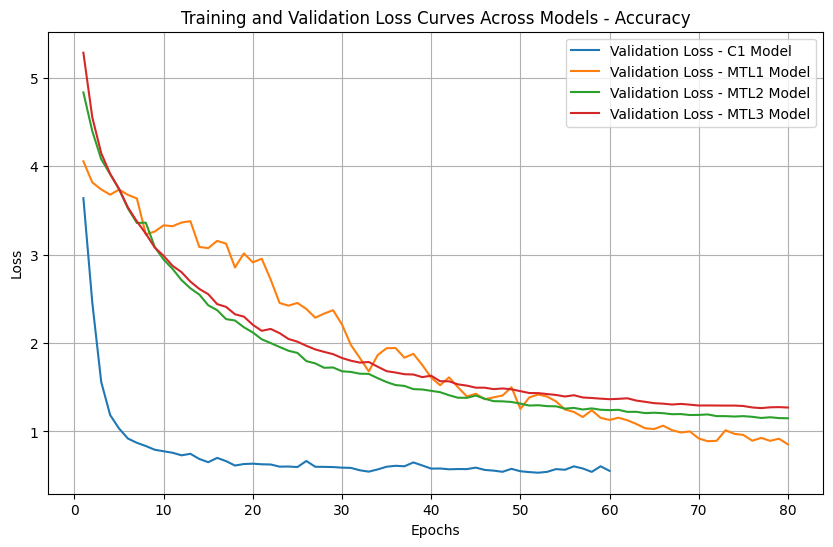

In [ ]:
# Create a figure
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(His_model_1.history["val_loss"]) + 1), His_model_1.history["val_loss"], label="Validation Loss - C1 Model")
plt.plot(np.arange(1, len(His_model_4.history["val_classification_output_loss"]) + 1), His_model_4.history["val_classification_output_loss"], label="Validation Loss - MTL1 Model")
plt.plot(np.arange(1, len(His_model_5.history["val_classification_output_loss"]) + 1), His_model_5.history["val_classification_output_loss"], label="Validation Loss - MTL2 Model")
plt.plot(np.arange(1, len(His_model_6.history["val_classification_output_loss"]) + 1), His_model_6.history["val_classification_output_loss"], label="Validation Loss - MTL3 Model")


# Add grid, labels, legend, and title
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves Across Models - Classification')

# Save and show the plot
plt.savefig("summary_class_loss.png")
plt.show()

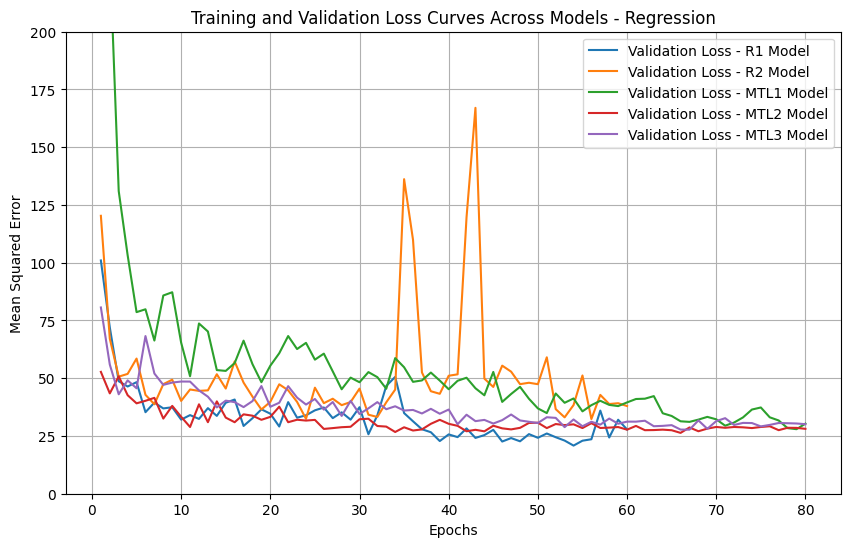

In [ ]:
# Create a figure
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(His_model_2.history["val_loss"]) + 1), His_model_2.history["val_loss"], label="Validation Loss - R1 Model")
plt.plot(np.arange(1, len(His_model_3.history["val_loss"]) + 1), His_model_3.history["val_loss"], label="Validation Loss - R2 Model")
plt.plot(np.arange(1, len(His_model_4.history["val_price_output_mean_squared_error"]) + 1), His_model_4.history["val_price_output_mean_squared_error"], label="Validation Loss - MTL1 Model")
plt.plot(np.arange(1, len(His_model_5.history["val_price_output_mean_squared_error"]) + 1), His_model_5.history["val_price_output_mean_squared_error"], label="Validation Loss - MTL2 Model")
plt.plot(np.arange(1, len(His_model_6.history["val_price_output_mean_squared_error"]) + 1), His_model_6.history["val_price_output_mean_squared_error"], label="Validation Loss - MTL3 Model")

# Add grid, labels, legend, and title
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Loss Curves Across Models - Regression')

# Save and show the plot
plt.savefig("summary_reg_loss.png")
plt.show()